In [ ]:
import os
import keras
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense

In [3]:


# Set up data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(
    'Sign-Language-Digits-Dataset/train',
    target_size=(224, 224),
    batch_size=10,
    shuffle=True,
    classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

test_batches = test_datagen.flow_from_directory(
    'Sign-Language-Digits-Dataset/test',
    target_size=(224, 224),
    batch_size=10,
    classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

valid_batches = test_datagen.flow_from_directory(
    'Sign-Language-Digits-Dataset/valid',
    target_size=(224, 224),
    batch_size=10,
    classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])



Found 1712 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [ ]:
# Load pre-trained MobileNet model
mobile_net = tf.keras.applications.mobilenet.MobileNet()
x = mobile_net.layers[-2].output
output = Dense(units=10, activation='softmax')(x)
model = tf.keras.Model(inputs=mobile_net.input, outputs=output)

# Freeze base model layers
for layer in model.layers[:-23]:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])



In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

In [8]:
# Train the model with data augmentation
history = model.fit(
    train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    verbose=2,
    callbacks = [early_stopping]
)




Epoch 1/20
172/172 - 217s - loss: 0.1760 - accuracy: 0.9457 - val_loss: 0.0960 - val_accuracy: 0.9700 - 217s/epoch - 1s/step
Epoch 2/20
172/172 - 228s - loss: 0.1914 - accuracy: 0.9428 - val_loss: 0.0959 - val_accuracy: 0.9667 - 228s/epoch - 1s/step
Epoch 3/20
172/172 - 226s - loss: 0.1176 - accuracy: 0.9632 - val_loss: 0.2023 - val_accuracy: 0.9600 - 226s/epoch - 1s/step
Epoch 4/20
172/172 - 220s - loss: 0.1281 - accuracy: 0.9609 - val_loss: 0.2620 - val_accuracy: 0.9333 - 220s/epoch - 1s/step
Epoch 5/20
172/172 - 222s - loss: 0.1398 - accuracy: 0.9626 - val_loss: 0.0889 - val_accuracy: 0.9767 - 222s/epoch - 1s/step
Epoch 6/20
172/172 - 217s - loss: 0.1062 - accuracy: 0.9731 - val_loss: 0.1478 - val_accuracy: 0.9667 - 217s/epoch - 1s/step
Epoch 7/20
172/172 - 221s - loss: 0.1000 - accuracy: 0.9708 - val_loss: 0.2692 - val_accuracy: 0.9433 - 221s/epoch - 1s/step
Epoch 8/20
172/172 - 215s - loss: 0.0983 - accuracy: 0.9778 - val_loss: 0.0274 - val_accuracy: 0.9900 - 215s/epoch - 1s/step


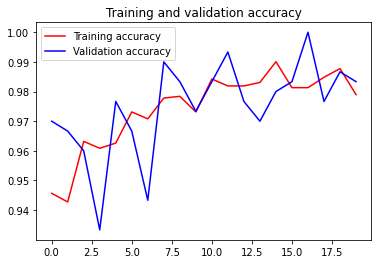

In [9]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [10]:
# Save the trained model
model.save('sign_language_model.h5')


In [12]:
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

# Load the Sign Language model
model = tf.keras.models.load_model('sign_language_model.h5')

# Define a function to preprocess the input image
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    return img

# Create a window to display the camera feed
cv2.namedWindow("Sign Language Detection")

# Start the camera capture
cap = cv2.VideoCapture(0)

# Loop through each frame from the camera
while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    # Preprocess the frame
    img = preprocess_image(frame)

    # Make a prediction
    prediction = model.predict(img)

    # Get the predicted class label
    class_label = np.argmax(prediction)

    # Convert the class label to a string
    if class_label == 0:
        class_string = 'Zero'
    elif class_label == 1:
        class_string = 'One'
    elif class_label == 2:
        class_string = 'Two'
    elif class_label == 3:
        class_string = 'Three'
    elif class_label == 4:
        class_string = 'Four'
    elif class_label == 5:
        class_string = 'Five'
    elif class_label == 6:
        class_string = 'Six'
    elif class_label == 7:
        class_string = 'Seven'
    elif class_label == 8:
        class_string = 'Eight'
    elif class_label == 9:
        class_string = 'Nine'
    else:
        class_string = 'Unknown'

    # Draw the predicted class label on the frame
    cv2.putText(frame, class_string, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow("Sign Language Detection", frame)

    # Check if the user has pressed the ESC key to exit
    if cv2.waitKey(1) == 27:
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()
